### Binary Classification | Threat Detection | Kolmogorov-Arnold Network Architecture

In [1]:
##################################################################################################################################################################################################################################
## Data Preprocessing | Handling Infinite Values
##################################################################################################################################################################################################################################
import pandas as pd
import numpy as np

# Load the shuffled combined dataset
data_path = '/home/jbenyam/PCAP-threatdetection-IOT/dataset/csv/sampled_traffic_raw.csv'
sampled_data = pd.read_csv(data_path)

## Create a new binary feature to indicate whether the 'Rate' was infinite
sampled_data['Rate_is_infinite'] = sampled_data['Rate'] == np.inf

# Replace infinite values with a large constant (e.g., maximum finite value in the dataset or an arbitrary large value)
max_finite_rate = sampled_data[sampled_data['Rate'] != np.inf]['Rate'].max()
sampled_data['Rate'].replace(np.inf, max_finite_rate * 10000, inplace=True)


/tmp/ipykernel_1776087/3893005688.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sampled_data['Rate'].replace(np.inf, max_finite_rate * 10000, inplace=True)


In [3]:
# Import necessary libraries
import logging  # For logging progress and status
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization

# Import PyTorch for building and training the neural network
import torch
import torch.nn as nn
import torch.optim as optim

# Import KAN library components (assuming the library is named 'deepkan')
from deepkan import RBFKAN  # Import the RBFKAN model class

# For splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# For evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# For handling imbalanced data (undersampling)
from imblearn.under_sampling import RandomUnderSampler

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# Set up logging for verbose output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
#######################################################################################################################
######################## Data Preparation and Handling Imbalanced Classes #############################################
#######################################################################################################################

# Load your data into 'sampled_data' DataFrame
# For example:
# sampled_data = pd.read_csv('your_data.csv')

# Ensure that 'sampled_data' is already loaded and contains a 'label' column with 0 for benign and 1 for attack

# Log the total number of records
logging.info(f"Total Records: {len(sampled_data)}")

# Log the count of benign and attack records
logging.info(f"Benign Records: {len(sampled_data[sampled_data['label'] == 0])}")
logging.info(f"Attack Records: {len(sampled_data[sampled_data['label'] == 1])}")

# Separate features and labels
X = sampled_data.drop('label', axis=1)  # Features
y = sampled_data['label']  # Labels

# Log the original class distribution
logging.info("Original class distribution:")
logging.info(y.value_counts())

# Handle class imbalance by undersampling the majority class (attack records)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Log the resampled class distribution
logging.info("Resampled class distribution:")
logging.info(pd.Series(y_resampled).value_counts())

# Now we have a balanced dataset

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Log the dimensions of the training and testing sets
logging.info(f"Training set shape: {X_train.shape}")
logging.info(f"Testing set shape: {X_test.shape}")


2024-09-21 19:16:59,453 - INFO - Total Records: 11200865
2024-09-21 19:16:59,525 - INFO - Benign Records: 1098191
2024-09-21 19:17:00,464 - INFO - Attack Records: 10102674
2024-09-21 19:17:01,003 - INFO - Original class distribution:
2024-09-21 19:17:01,035 - INFO - label
1    10102674
0     1098191
Name: count, dtype: int64
2024-09-21 19:17:02,402 - INFO - Resampled class distribution:
2024-09-21 19:17:02,407 - INFO - label
0    1098191
1    1098191
Name: count, dtype: int64
2024-09-21 19:17:03,016 - INFO - Training set shape: (1757105, 33)
2024-09-21 19:17:03,017 - INFO - Testing set shape: (439277, 33)


In [5]:
#######################################################################################################################
######################## Data Preprocessing ###########################################################################
#######################################################################################################################

# Initialize the scaler for feature normalization
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
# Convert features to float tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Convert labels to float tensors and reshape to match output dimensions
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [23]:
#######################################################################################################################
######################## Model Building | Kolmogorov-Arnold Network (KAN) Using RBFKAN ################################
#######################################################################################################################

# Log the start of model building
logging.info("Starting model building with RBFKAN architecture...")

# Define the input and output dimensions
input_dim = X_train_tensor.shape[1]  # Number of features
output_dim = 1  # Binary classification (output dimension is 1)

# Define the hidden layer dimensions
hidden_dims = [64, 32]  # You can adjust the number of neurons in hidden layers

# Create an RBFKAN instance with the specified architecture
model = FixedRBFKAN([input_dim] + hidden_dims + [output_dim])

# Move the model to the device
model.to(device)

# Log the completion of model building
logging.info("Model building completed.")

# Print the model architecture
print(model)


2024-09-22 08:31:27,697 - INFO - Starting model building with RBFKAN architecture...
2024-09-22 08:31:27,712 - INFO - Model building completed.


FixedRBFKAN(
  (layers): ModuleList(
    (0): FixedRBFKANLayer(
      (base_activation): SiLU()
      (base_linear): Linear(in_features=33, out_features=64, bias=True)
      (rbf_linear): FixedRBFLinear()
    )
    (1): FixedRBFKANLayer(
      (base_activation): SiLU()
      (base_linear): Linear(in_features=64, out_features=32, bias=True)
      (rbf_linear): FixedRBFLinear()
    )
    (2): FixedRBFKANLayer(
      (base_activation): SiLU()
      (base_linear): Linear(in_features=32, out_features=1, bias=True)
      (rbf_linear): FixedRBFLinear()
    )
  )
)


In [24]:
# Ensuring all parameters are on correct device
for name, param in model.named_parameters():
    print(f"{name} is on device {param.device}")


layers.0.base_linear.weight is on device cuda:0
layers.0.base_linear.bias is on device cuda:0
layers.0.rbf_linear.grid is on device cuda:0
layers.0.rbf_linear.spline_weight is on device cuda:0
layers.1.base_linear.weight is on device cuda:0
layers.1.base_linear.bias is on device cuda:0
layers.1.rbf_linear.grid is on device cuda:0
layers.1.rbf_linear.spline_weight is on device cuda:0
layers.2.base_linear.weight is on device cuda:0
layers.2.base_linear.bias is on device cuda:0
layers.2.rbf_linear.grid is on device cuda:0
layers.2.rbf_linear.spline_weight is on device cuda:0


In [25]:
# Print the model architecture
from torchsummary import summary
summary(model, input_size=(input_dim,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    FixedRBFLinear-1                   [-1, 64]               0
              SiLU-2                   [-1, 33]               0
            Linear-3                   [-1, 64]           2,176
  FixedRBFKANLayer-4                   [-1, 64]               0
    FixedRBFLinear-5                   [-1, 32]               0
              SiLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
  FixedRBFKANLayer-8                   [-1, 32]               0
    FixedRBFLinear-9                    [-1, 1]               0
             SiLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
 FixedRBFKANLayer-12                    [-1, 1]               0
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
-----------------------------------

In [7]:
#######################################################################################################################
######################## Model Training Setup #########################################################################
#######################################################################################################################

# Define the loss function for binary classification
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer (Adam optimizer is used here)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

# Check if GPU is available and move model and data to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device: {device}')

# Move the model to the device
model.to(device)

# Move tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Set training parameters
num_epochs = 10  # Number of epochs to train
batch_size = 32  # Batch size for training

# Create DataLoader for batch processing
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create DataLoader for training data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


2024-09-21 19:18:55,098 - INFO - Using device: cuda


In [8]:
#######################################################################################################################
######################## Model Training ###############################################################################
#######################################################################################################################

# Log the start of model training
logging.info("Starting model training...")

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Initialize running loss for the epoch

    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        
        # Flatten outputs and labels to 1D tensors
        outputs = outputs.view(-1)
        labels = labels.view(-1)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate the running loss
        running_loss += loss.item()
    
    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    logging.info(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Log the completion of model training
logging.info("Model training completed.")


2024-09-21 19:19:21,297 - INFO - Starting model training...
2024-09-21 19:22:11,516 - INFO - Epoch [1/10], Loss: 0.0639
2024-09-21 19:25:22,490 - INFO - Epoch [2/10], Loss: 0.0621
2024-09-21 19:28:25,711 - INFO - Epoch [3/10], Loss: 0.0615
2024-09-21 19:31:32,782 - INFO - Epoch [4/10], Loss: 0.0614
2024-09-21 19:34:45,913 - INFO - Epoch [5/10], Loss: 0.0636
2024-09-21 19:37:45,113 - INFO - Epoch [6/10], Loss: 0.0616
2024-09-21 19:40:57,004 - INFO - Epoch [7/10], Loss: 0.0609
2024-09-21 19:44:08,199 - INFO - Epoch [8/10], Loss: 0.0607
2024-09-21 19:47:18,879 - INFO - Epoch [9/10], Loss: 0.0609
2024-09-21 19:50:31,302 - INFO - Epoch [10/10], Loss: 0.0610
2024-09-21 19:50:31,303 - INFO - Model training completed.


In [11]:
#######################################################################################################################
######################## Saving KAN-model ###############################################################################
#######################################################################################################################

import os   # For file operations

save_dir = '/home/jbenyam/PCAP-threatdetection-IOT/models'  # Directory to save the model
save_filename = 'KAN_binary_classification.pth'  # Model filename
save_path = os.path.join(save_dir, save_filename)

# Save the model's state_dict to the specified file
torch.save(model.state_dict(), save_path)  # Save the model

print(f"Model saved successfully to: {save_path}")


Model saved successfully to: /home/jbenyam/PCAP-threatdetection-IOT/models/KAN_binary_classification.pth


In [22]:
##############################################################################################################################################
############################ Subclassing RBFLinear and RBFKANLayer to Use Fixed Grids for Radial Basis Functions (RBFs) ################################################################
#########################################################################################################################################################################################

import deepkan
import torch
import torch.nn as nn

# Subclass FixedRBFLinear to handle the device movement of internal tensors
class FixedRBFLinear(deepkan.RBFLinear):
    def forward(self, x):
        # Use local variables without reassigning self.grid and self.spline_weight
        grid = self.grid.to(x.device)            # Move grid to the same device as x
        spline_weight = self.spline_weight.to(x.device)  # Move spline_weight to the same device

        x = x.unsqueeze(-1)  # Unsqueeze to match dimensions
        basis = torch.exp(-((x - grid) / ((self.grid_max - self.grid_min) / (self.num_grids - 1))) ** 2)
        return basis.reshape(basis.size(0), -1).matmul(spline_weight)


# Modify RBFKANLayer to use FixedRBFLinear
class FixedRBFKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, **kwargs):
        super(FixedRBFKANLayer, self).__init__()
        # Initialize base_activation
        self.base_activation = nn.SiLU()
        # Initialize base_linear
        self.base_linear = nn.Linear(input_dim, output_dim)
        # Replace the RBFLinear layer with the FixedRBFLinear
        self.rbf_linear = FixedRBFLinear(input_dim, output_dim, **kwargs)
        self.use_base_update = kwargs.get('use_base_update', True)

    def forward(self, x):
        ret = self.rbf_linear(x)
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret


# Subclass RBFKAN to use FixedRBFKANLayer
class FixedRBFKAN(deepkan.RBFKAN):
    def __init__(self, layers_hidden, **kwargs):
        super().__init__(layers_hidden, **kwargs)
        self.layers = nn.ModuleList()
        for i in range(len(layers_hidden) - 1):
            # Replace RBFKANLayer with FixedRBFKANLayer
            self.layers.append(FixedRBFKANLayer(layers_hidden[i], layers_hidden[i+1], **kwargs))


2024-09-22 08:34:15,051 - INFO - Confusion Matrix:


[[102278 117364]
 [ 72831 146804]]


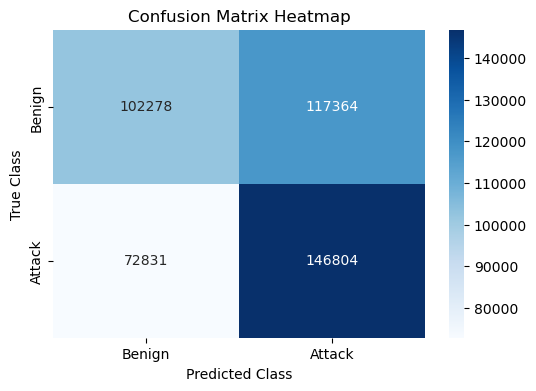

2024-09-22 08:34:15,577 - INFO - 
Classification Report:
2024-09-22 08:34:15,671 - INFO - 
ROC-AUC Score: 0.4761


              precision    recall  f1-score   support

         0.0       0.58      0.47      0.52    219642
         1.0       0.56      0.67      0.61    219635

    accuracy                           0.57    439277
   macro avg       0.57      0.57      0.56    439277
weighted avg       0.57      0.57      0.56    439277



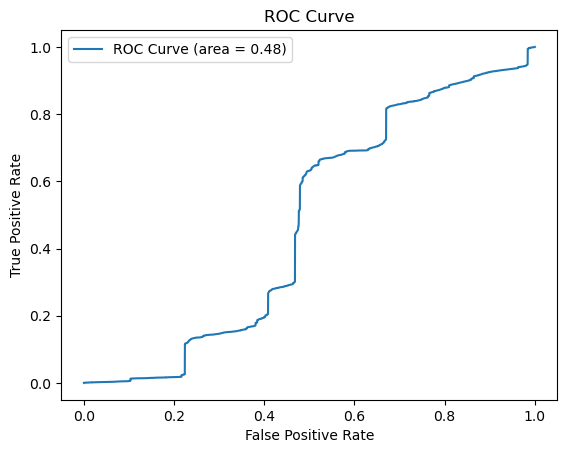

2024-09-22 08:34:15,799 - INFO - ROC Curve generated.


In [26]:
#######################################################################################################################
######################## Model Evaluation (Memory-Efficient Version) ##################################################
#######################################################################################################################

from torch.utils.data import DataLoader

# Create TensorDataset for test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define a suitable batch size for evaluation (adjust based on your memory constraints)
eval_batch_size = 50  # You may need to reduce this if memory is still an issue

# Create DataLoader for test data
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False)

# Initialize lists to collect outputs and labels
all_probabilities = []
all_labels = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Compute the model outputs on the test batch
        outputs = model(inputs)

        # Apply sigmoid activation to get probabilities
        probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()

        # Append probabilities and labels to lists
        all_probabilities.extend(probabilities)
        all_labels.extend(labels.cpu().numpy().flatten())

# Convert lists to numpy arrays
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)

# Convert probabilities to binary predictions (threshold at 0.5)
y_pred = (all_probabilities >= 0.5).astype(int)
y_true = all_labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Log the confusion matrix
logging.info("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_true, y_pred)
logging.info("\nClassification Report:")
print(class_report)

# ROC-AUC Score
roc_auc = roc_auc_score(y_true, all_probabilities)
logging.info(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, all_probabilities)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Log ROC-AUC completion
logging.info("ROC Curve generated.")


## Notes on Evaluation Criteria:


### Model Performance:
#### Moderate Precision and Recall: Precision and recall are around 0.56-0.58 for both classes, indicating moderate predictive power.
#### Class Imbalance Handling: Both classes have nearly equal support, so class imbalance is not a major issue here.
#### Higher Recall for Attacks: The model is better at detecting attacks (67% recall) than benign traffic (47% recall).
#### Low Overall Accuracy: An accuracy of 57% suggests the model is not performing well.

###### Concerns:
- ROC-AUC Below 0.5: This is concerning as it suggests the model's ability to rank positive instances higher than negative ones is poor.
- Possible Overfitting or Underfitting: The poor performance may be due to overfitting, underfitting, or data issues.

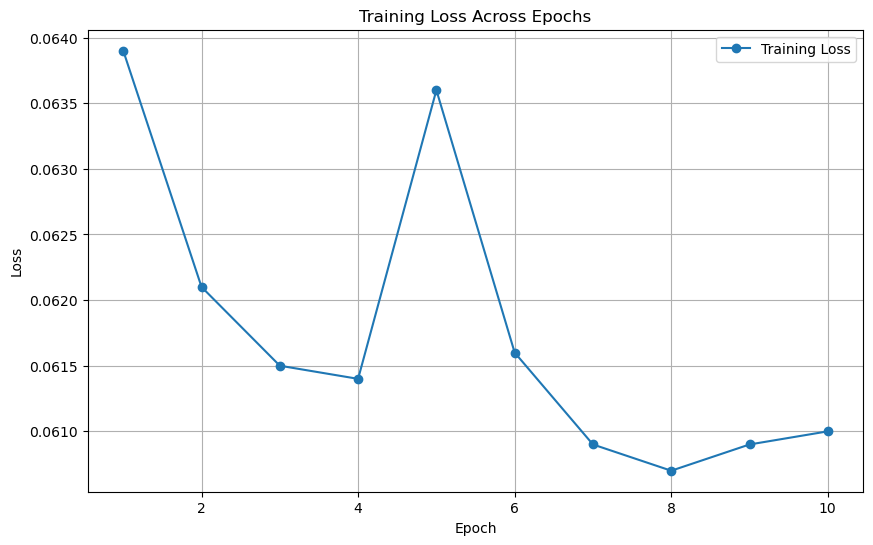

In [28]:
#######################################################################################################################
######################## Visualization of Loss Gradient - KAN Network Architecture ####################################################
#######################################################################################################################

import matplotlib.pyplot as plt

# Training loss values for each epoch
train_losses = [0.0639, 0.0621, 0.0615, 0.0614, 0.0636, 0.0616, 0.0609, 0.0607, 0.0609, 0.0610]

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_losses, label='Training Loss', marker='o')

plt.title('Training Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()



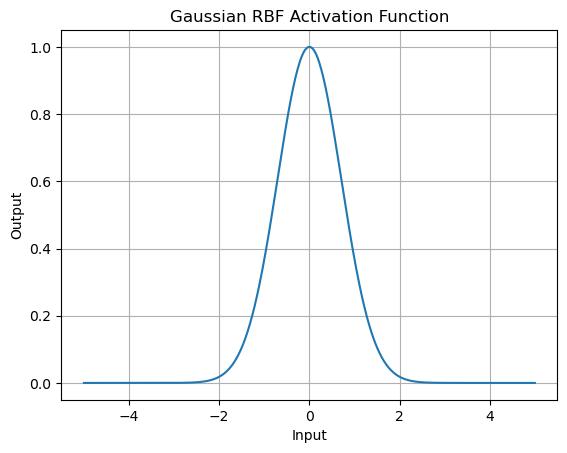

Gaussian RBF Activation Function: φ(x) = exp(-γ * (x - c)²)


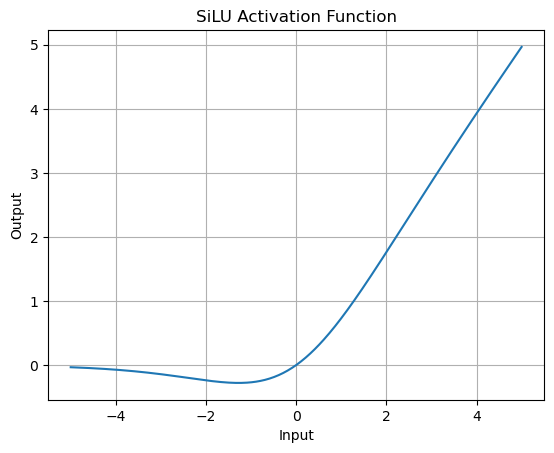

SiLU Activation Function: f(x) = x * sigmoid(x)


In [27]:
#######################################################################################################################
######################## Visualization of Univariate Activation Functions #############################################
#######################################################################################################################

# Define a range of input values for visualization
x_values = np.linspace(-5, 5, 400)

# Radial Basis Function (Gaussian RBF) Activation
# Assume gamma = 1, center c = 0 for simplicity
gamma = 1
c = 0

# Compute the RBF outputs
rbf_outputs = np.exp(-gamma * (x_values - c) ** 2)

# Plot the Gaussian RBF activation function
plt.figure()
plt.plot(x_values, rbf_outputs)
plt.title('Gaussian RBF Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)
plt.show()

# Display mathematical expression
print("Gaussian RBF Activation Function: φ(x) = exp(-γ * (x - c)²)")

# SiLU Activation Function (used as base_activation in RBFKANLayer)
# Compute the SiLU activation function outputs
silu_outputs = x_values * (1 / (1 + np.exp(-x_values)))

# Plot the SiLU activation function
plt.figure()
plt.plot(x_values, silu_outputs)
plt.title('SiLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)
plt.show()

# Display mathematical expression
print("SiLU Activation Function: f(x) = x * sigmoid(x)")
